In [ ]:
# 먼저 완전한 방전 전압 곡선을 사용해서 모델을 학습

In [1]:
import pandas as pd
import os
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from glob import glob
from torch.optim.lr_scheduler import StepLR

In [2]:
# figure를 위한 라이브러리
import matplotlib as mpl
import matplotlib.lines as mlines
mpl.rcParams['font.size'] = 30

In [3]:
path = os.getcwd()
print(path)

/content


In [4]:
def all_load_csvs(csv_paths):
    ## 파일에 있는 데이터들을 전치리 한후에 모두 다 병합
    data = []
    cycles = []
   
    for path in (csv_paths):
        assert os.path.exists(path) #assert는 os에 해당 path가 존재하지 않으면 AssertError를 발생한다.
        df = pd.read_csv(path)
#         if df.Cycle_Index.unique().shape[0] > 2000:
#             continue
        print(df.Cycle_Index.unique().shape[0])
        df = df[df['Step_Index'] == 10] # discharge
        df = df[df['Step_Time'] > 0] # remove outliers
        df = df[df['Step_Time'] < 5000] #remove outliers
        df = df[df["Cycle_Index"] > 0] # remove outliers
            
        # df = df[df["Voltage"] <3.21] # data reduction part -> 데이터의 특징을 더 잘나타낼 수 있는 부분 선택
        # df = df[df["Voltage"] >2.95] # 원래는 2.95
        df["Charge_Capacity"] /= 1.1 # 공칙용량으로 나눠줌 >> 즉 charge_capcity를 퍼센트로 확인 가능
            
        
        data.append(df)
        cycle = df["Cycle_Index"].unique() # 각 파일당 사이클 횟수 저장
        cycles.append(cycle)
        
        print (f"total points in {path}", df.shape)
    
    
    return data, cycles


In [5]:
def load_csvs(csv_paths):
    ## 파일에 있는 데이터들을 전치리 한후에 모두 다 병합
    data = []
    cycles = []
   
    for path in (csv_paths):
        assert os.path.exists(path) #assert는 os에 해당 path가 존재하지 않으면 AssertError를 발생한다.
        df = pd.read_csv(path)
#         if df.Cycle_Index.unique().shape[0] > 2000:
#             continue
        print(df.Cycle_Index.unique().shape[0])
        df = df[df['Step_Index'] == 10]
        df = df[df['Step_Time'] > 0] # remove outliers
        df = df[df['Step_Time'] < 5000] #remove outliers
        df = df[df["Cycle_Index"] > 0] # remove outliers
            
        df = df[df["Voltage"] <3.21] # data reduction part -> 데이터의 특징을 더 잘나타낼 수 있는 부분 선택
        # df = df[df["Voltage"] >2.9] # 학습시킬 voltage segment구간>> 이걸 바꿔가면서 모델링 진행하면됨 원래 2.95
        df = df[df["Voltage"] >2]
        df["SOH"] = df['Charge_Capacity'] / 1.1 # 공칙용량으로 나눠줌 >> 즉 charge_capcity를 퍼센트로 확인 가능
            
        
        data.append(df)
        cycle = df["Cycle_Index"].unique() # 각 파일당 사이클 횟수 저장
        cycles.append(cycle)
        
        print (f"total points in {path}", df.shape)
    
    
    return data, cycles


In [6]:
def plot_cycles(data, cycles):
    print("plotting...")
    for d, cycle in zip(data, cycles):
        for i,c in enumerate(cycle):
            cycle_data = d[d.Cycle_Index == c]
            time, voltage = cycle_data['Step_Time'].values, cycle_data.Voltage 
            try: #동일한 시작점으로 맞춰주는 과정
                time = time - time[0] 
            except:
                print (time, voltage, "skipping")
                continue
            plt.xlabel("time")
            plt.ylabel("voltage")
            plt.plot(time,voltage)

    plt.show()

In [7]:
def fit_spline(data, cycles,length ,no_points=500): # no_points 구간별 point 개수
    i = 0
    
    for cycle, d in zip (cycles, data):
        cell_np = []
        for index, c in enumerate (cycle):
            cycle_data = d[d["Cycle_Index"] == c]
            
            time, voltage, SOH, ind = cycle_data.Step_Time.values, cycle_data.Voltage, cycle_data.SOH, cycle_data.Cycle_Index
            time = time - time[0]
            
            # using spline function to to make dimensions of all cycles equal (to create equal number of points in every cycle)
            ius = InterpolatedUnivariateSpline(time, voltage, k=1) # class 반환

            # creating linear space 0, 200 of 20,000 points >> 0에서 700사이의 20000개의 일정한 간격의 요소를 만듬
            xi = np.linspace(0,700, 20000)
            yi_test = ius(xi) # 불연속인 y값을 대체할 yi_test값 생성

            index_1 = np.argmin(np.abs(yi_test[:1000] - 3.2)) #argmin 최솟값 위치 색인 
            # index_2 = np.argmin(np.abs(yi_test - 3)) # 원래 3
            index_2 = np.argmin(np.abs(yi_test - (3.2 - length))) # 원래 3

            indices = np.linspace(index_1, index_2, no_points).astype(int)

            #discarding points that are greater than time
#             xi = xi[xi < time[-1]]
            #creating indices equal to number of points of xi and selecting 400 equidistant integers
#             indices = np.linspace(0, time[-1]*100 -1, no_points).astype(int)
#             #selecting time at specified indices
            xi = xi[indices]
            yi = ius(xi)
            # if yi[yi<2.998].any():
            #     continue
# 각 변수별 일차원 배열을 생성해주는 과정                       
            ind = np.zeros_like(xi) + ind.values[0] #ind = step_time
            SOH = np.zeros_like(xi) + np.max(SOH)
            cell_np.append(np.array([xi, yi, SOH, ind])) # 리스트에 합침
        cell_np = np.concatenate(cell_np, axis=1) 
        cell_np = np.transpose(cell_np, (1,0)) 
        data[i] = pd.DataFrame(cell_np, columns = ['Step_Time', 'Voltage', 'SOH', 'Cycle_Index']) # 데이터 프레임화
        i+=1
        
    return data

In [8]:
def find_error(data, cycles): # fit_spline 함수 에러 뜬 데이터 오류난 부분의 인덱스를 잡는 함수
    
    for d, cycle in zip(data, cycles):
        for i,c in enumerate(cycle):
            cycle_data = d[d.Cycle_Index == c]
            time, voltage = cycle_data['Step_Time'].values, cycle_data.Voltage 
            
            pts = len(time)
            
            for i in range(pts -1):
                if time[i + 1] - time[i] <= 0:
                    print (f"Error is in {c} cycle at time {time[i]}")

In [9]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 전처리

In [10]:
# mit_csv have pathes of all csv files in raw_mit file(즉 방전상태 뿐만아니라 충전과정 까지 포함한 데이터) > 총 10개의 모집단
# mit_csvs = glob("/content/drive/MyDrive//battery capcity estimation//Battery SOH//DATA//MIT discharge data//*csv") # 방전 그래프 
mit_csvs = glob("/content/drive/MyDrive//battery capcity estimation//data//*csv") # 방전 그래프 
# mit_csvs = glob("/content/drive/MyDrive//battery capcity estimation//data//CSV from pkl//*csv") # 전체 충방전 그래프 그릴때

#glob("./Capacity_data/MIT/*")
for csv in mit_csvs:
    print (csv)
# b1이 들어간 파일은 mit_csv리스트에 담지 않는다
mit_csvs = [i for i in mit_csvs if "b1c21" not in i]


/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-40per_3C_CH26_b1c25_discharge.csv
/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_5_4C-80per_5_4C_CH12_b1c20_discharge.csv
/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-40per_3C_CH25_b1c24_discharge.csv
/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_5_4C-80per_5_4C_CH11_b1c21_discharge.csv
/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_5_4C-60per_3C_CH16_b1c15_discharge.csv
/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-40per_3_6C_CH34_b1c27_discharge.csv
/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-50per_3_6C_CH36_b1c31_discharge.csv
/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_8C-25per_3_6C_CH45_b1c42_discharge_corrected.csv
/content/drive/MyDrive//battery capcity estimation//data/2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv
/content/drive/MyDrive//batter

In [11]:
# reducted entire voltage curve
mit_data, mit_cycles = load_csvs(mit_csvs)
# plot_cycles(mit_data, mit_cycles)

852
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-40per_3C_CH26_b1c25_discharge.csv (288494, 9)
532
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_5_4C-80per_5_4C_CH12_b1c20_discharge.csv (173273, 9)
1015
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-40per_3C_CH25_b1c24_discharge.csv (338142, 9)
717
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_5_4C-60per_3C_CH16_b1c15_discharge.csv (242821, 9)
840
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-40per_3_6C_CH34_b1c27_discharge.csv (283183, 9)
874
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-50per_3_6C_CH36_b1c31_discharge.csv (291392, 9)
700
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_8C-25per_3_6C_CH45_b1c42_discharge_corrected.csv (240259, 13)
170
total points 

In [12]:
# 모든 셀의 데이터를 fit spline함수 진행.
# full = 1.1
mit_d = fit_spline(mit_data.copy(), mit_cycles,1.1, no_points=500)

In [13]:
# # 모든 셀의 데이터를 fit spline함수 진행.
# segment version
# mit_d = fit_spline(mit_data.copy(), mit_cycles,0.2, no_points=500)

# test 데이터 추출

In [12]:
# reducted discharge voltage curve(data after reduction)
test_csvs = mit_csvs[5:-1]
test_csvs.pop(7)
test_csvs

['/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-50per_3_6C_CH36_b1c31_discharge.csv',
 '/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_8C-25per_3_6C_CH45_b1c42_discharge_corrected.csv',
 '/content/drive/MyDrive//battery capcity estimation//data/2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv',
 '/content/drive/MyDrive//battery capcity estimation//data/b1c1corrected.csv',
 '/content/drive/MyDrive//battery capcity estimation//data/b1c2corrected.csv',
 '/content/drive/MyDrive//battery capcity estimation//data/b3c16corrected.csv',
 '/content/drive/MyDrive//battery capcity estimation//data/b1c0.csv',
 '/content/drive/MyDrive//battery capcity estimation//data/b1c9.csv']

In [13]:
test_csvs, test_cycles = load_csvs(test_csvs)

874
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-50per_3_6C_CH36_b1c31_discharge.csv (291392, 9)
700
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_8C-25per_3_6C_CH45_b1c42_discharge_corrected.csv (240259, 13)
170
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv (52984, 9)
2158
total points in /content/drive/MyDrive//battery capcity estimation//data/b1c1corrected.csv (722867, 9)
2235
total points in /content/drive/MyDrive//battery capcity estimation//data/b1c2corrected.csv (753645, 9)
1637
total points in /content/drive/MyDrive//battery capcity estimation//data/b3c16corrected.csv (400729, 9)
1850
total points in /content/drive/MyDrive//battery capcity estimation//data/b1c0.csv (616534, 8)
1052
total points in /content/drive/MyDrive//battery capcity estimation//data/b1c9.csv (350438, 8)


In [14]:
test_cell_name = ['b1c31','b1c42','b2c1','b1c1','b1c2','b3c16','b1c0','b1c9']

In [46]:
# full curve version
# test_data = []
# for test,cycle in zip(test_csvs,test_cycles):
#   temp_data = fit_spline([test], [cycle],1.1, no_points=500)
#   test_data.append(temp_data)

In [27]:
# segment version
test_data = []
for test,cycle in zip(test_csvs,test_cycles):
  temp_data = fit_spline([test], [cycle],0.2, no_points=500)
  test_data.append(temp_data)

# 회귀모델링

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
len(mit_d)*0.8

12.0

In [ ]:
import random
list_d = [1,2,3,4,5,6,7,8,9,10,11,1,2,13,14]
sample_d=random.sample(list_d,12)
sample_d

[1, 4, 14, 6, 2, 5, 11, 10, 1, 7, 3, 9]

In [ ]:
temp = mit_d
train = pd.DataFrame()
train2=[]
test = []
for i,t in enumerate(temp):
  t.rename(columns={'SOH':'Capacity'},inplace=True)
  if i in sample_d:
    train = pd.concat([train,t],axis=0)
    train2.append(t)
  else:
    test.append(t)

In [ ]:
X_train = train.loc[:,['Cycle_Index','Step_Time','Voltage']]
y_train = train['Capacity']

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [ ]:
test[0].loc[:,['Cycle_Index','Step_Time','Voltage','Capacity']]

,Cycle_Index,Step_Time,Voltage,Capacity
0,1.0,6.055303,3.200002,0.977084
1,1.0,7.420371,3.198559,0.977084
2,1.0,8.820441,3.197078,0.977084
3,1.0,10.220511,3.195648,0.977084
4,1.0,11.585579,3.194523,0.977084
...,...,...,...,...
425995,852.0,618.900945,2.261067,0.800940
425996,852.0,620.161008,2.230819,0.800940
425997,852.0,621.386069,2.195976,0.800940
425998,852.0,622.646132,2.152571,0.800940


In [ ]:
X_test = test[2].loc[:,['Cycle_Index','Step_Time','Voltage']]
y_test = test[2]['Capacity']

In [ ]:
lr.score(X_test,y_test)

0.7592323662927033

In [ ]:
y_pred = lr.predict(X_test)
y_pred

array([0.96961623, 0.96934897, 0.96907485, ..., 0.68626256, 0.67554784,
       0.66139008])

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_pred,y_test)

0.016816497511437923

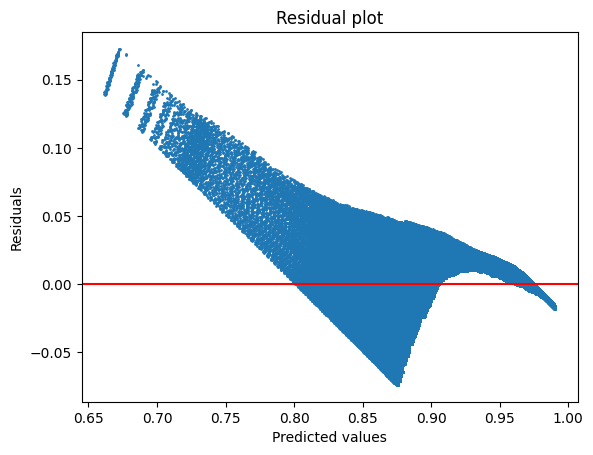

In [ ]:
residuals = y_test - y_pred

# residual plot 그리기
plt.scatter(y_pred, residuals,s=1)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

In [ ]:
len(train2)

11

In [ ]:
len(test)

4

In [ ]:
temp = train2
y_train= []
X_train = np.empty((0,500,2), int)
for data in temp:
  X = data.loc[:,['Step_Time','Voltage']]
  X=X.to_numpy()
  X=X.reshape(-1,500,2)
  X_train = np.append(X_train,X,axis=0)

  ci=data['Cycle_Index'].unique()

  for c in ci:
    soh=data.loc[data['Cycle_Index']==c,'Capacity'].unique()[0]
    y_train.append(soh)

In [ ]:
len(y_train)

11607

In [ ]:
X_train.shape

(11607, 500, 2)

In [ ]:
X_=X_train.reshape(X_train.shape[0], -1)
X_.shape

(11607, 1000)

In [ ]:
lr = LinearRegression()
lr.fit(X_,y_train)

LinearRegression()

In [ ]:
temp = [test[2]]
y_test= []
X_test = np.empty((0,500,2), int)
for data in temp:
  X = data.loc[:,['Step_Time','Voltage']]
  X=X.to_numpy()
  X=X.reshape(-1,500,2)
  X_test = np.append(X_test,X,axis=0)

  ci=data['Cycle_Index'].unique()

  for c in ci:
    soh=data.loc[data['Cycle_Index']==c,'Capacity'].unique()[0]
    y_test.append(soh)

In [ ]:
X_test=X_test.reshape(X_test.shape[0], -1)
X_test.shape

(1799, 1000)

In [ ]:
y_pred=lr.predict(X_test)

In [ ]:
lr.score(X_test,y_test)

0.9512909907685548

In [ ]:
mean_absolute_percentage_error(y_test,y_pred)

0.0076132407799161415

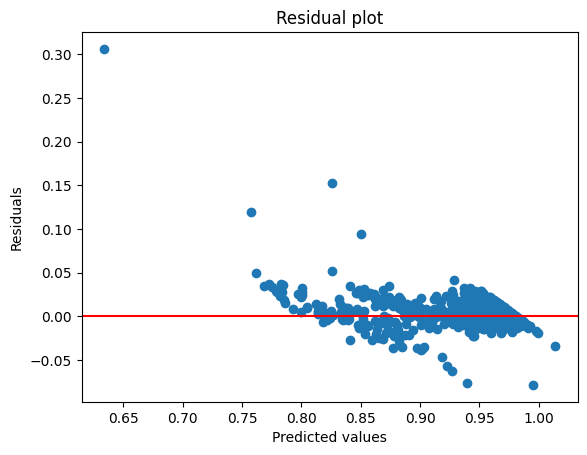

In [ ]:
residuals = y_test - y_pred

# residual plot 그리기
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

# 모델링

In [16]:
import torch.nn as nn
import torch.nn.functional as F


    
# creating a four layer neural network.
# number of elements in input layer = segment length x 2
# 2 hidden layers each with two hundred units

    
# Neural Net to predict capacity # 다층 신경망 구조
class CapacityNet(nn.Module):
    def __init__(self):
        super(CapacityNet, self).__init__()

        self.l1 = nn.Linear(in_features= int(500 * 2), out_features=400) # 입력차원 1000, 출력 400
        self.l2 = nn.Linear(in_features=400, out_features=400) # 입력차원 400, 출력 400
        self.l3 = nn.Linear(in_features=400, out_features=400) # 입력차원 400, 출력 400
        self.l4 = nn.Linear(in_features=400, out_features=200) # 입력차원 400, 출력 200
        self.l5 = nn.Linear(in_features=200, out_features=100) # 입력차원 200, 출력 100
        self.l6 = nn.Linear(in_features=100, out_features=1) # 입력차원 100, 출력 1
        
    def forward(self, x):
        x = F.relu(self.l1(x)) # reLu 
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        return self.l6(x)

    

In [17]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from bisect import bisect
  

# procesing data to get samples for training and testing
# minibatch gradient descnet 사용    
class CapacityDataset(Dataset):
    def __init__(self, data, type="train"):
        self.cycles = []

        for d in data:
            self.cycles.append(d.Cycle_Index.unique())
        self.data = data
#         self.window = window
        # cycles per cell
        self.spc = [cycle.shape[0] for cycle in  self.cycles]
        
    def __len__(self):
        return sum(self.spc)

    def __getitem__(self, idx):
        
        # the next three lines are locating the index in cycles of a particular cell
        
        cumsum = np.cumsum(self.spc)
        cell_no = bisect(cumsum, idx)
        ind = idx if cell_no == 0 else idx - cumsum[cell_no - 1]
        
        # picking the value of time, voltage, and capacity for the specified cycle during training or testing
        
        time_step = self.data[cell_no][self.data[cell_no].Cycle_Index == self.cycles[cell_no][ind]].Step_Time.values
        voltage = self.data[cell_no][self.data[cell_no].Cycle_Index == self.cycles[cell_no][ind]].Voltage.values
        capacity = self.data[cell_no][self.data[cell_no].Cycle_Index == self.cycles[cell_no][ind]].SOH.max()
        
        # choosing a segment of specified length from the discharge curve for training or testing
        # if random = True, the segment will start anywhere from start of curve to 400- length of segment
#         print (time_step.shape, voltage.shape, cell_no, ind, capacity )

#         segment_length = np.random.randint(self.window[0], self.window[1])
#         start = 0 if not self.random else np.random.randint(0, 400 - segment_length)
#         time_x = time_step[start: start+segment_length]
#         voltage_x = voltage[start: start+segment_length]
        # creating input / feature vector (segment length x2)
        # the vector has voltage values followed by the corresponding time values
#         x = np.zeros((voltage_x.shape[0]*2))
        x = np.zeros((voltage.shape[0]*2))
#         max_segment = np.zeros((self.max_points * 2)) 
        x[::2] = voltage
        x[1::2] = time_step / 100
#         x_random_seg = np.zeros(((self.window[1] - 1) * 2))
#         x_random_seg[:x.shape[0]] = x

#         max_segment[:x.shape[0]] = x


        return x , torch.from_numpy(np.array([capacity]))


In [ ]:
train_voltage_c = CapacityDataset(mit_d[:4]) # 보충자료에 의한 학습 입력 데이터로 바꿔주었다. 원래는 :5 였음
train_loader_c = DataLoader(train_voltage_c, batch_size=64, shuffle=True) # batch_size 64개 

# valid와 test는 한개의 데이터 셋으로 진행되므로 shuffle이 false여도 상관 없다.
valid_voltage_c = CapacityDataset([mit_d[4]])
valid_loader_c = DataLoader(valid_voltage_c, batch_size=64, shuffle=False) 

test_mit = CapacityDataset(test_data)
test_loader_mit = DataLoader(test_mit, batch_size=64, shuffle=False)

# Net to predict Capacity
net =  CapacityNet()
optimizer = torch.optim.Adam(net.parameters(), lr=0.000561) # optimizer로 adam을 사용하며 학습률은 0.000561이다.
criteria = torch.nn.MSELoss() # loss function : MSE
scheduler = StepLR(optimizer, step_size=4, gamma=0.99)


def train(net, best, train_set, test_set, optimizer, criteria, epoch, best_mape):
    for dset, mode in [(train_set, 'train'), (test_set, 'test')]: # looping over two dataloaders (train and test)
        if mode == "test":
            net.eval() # if testing, don't compute gradients 
        else:
            net.train()
        loss = 0
        preds = []
        target = []
        for ind, (x, y) in enumerate(dset): # looping over dataloader (train or test)
            x = x.float()  #converting datatype to float, data type of inputs must match the datatype of weights of network
            y = y.float()

            pred = net(x) # neural net forward is called with input x. it will return capacity
            loss = criteria(pred, y) # computing mean square error between predicted capacity and target capacity
#             print (mode)
            if mode == "test":
                preds.extend(pred.detach().numpy().reshape(-1)) # if test dataloader, save the predictions for further analysis
                target.extend(y.cpu().numpy())
            if mode == 'train':
                optimizer.zero_grad() # if train mode, if there are any gradients from previous time step, set them to 0
                loss.backward()  # back propagation
                optimizer.step() # updating the weights
            loss += loss.item()  # converting loss(pytorch tensor) to python object and adding the value to total loss
    
    mape =  mean_absolute_percentage_error(preds, target) # computing the error of epoch
    if mape < best_mape and mode == "test":
        best = copy.deepcopy(net) #if error is less than the best error observed so far. save the model
        best_mape = mape # current error is the least error so for. so setting it as the best mape
    print (f'Mode: {mode} __ Epoch: {epoch} __ Loss: {loss/len(dset)}, mape: {mape}, Best Mape: {best_mape}')
    return net, best, best_mape # return the trained net

In [ ]:
best_mape=4
best=None
for epoch in range(100):
    net, best, best_mape = train(net, best, train_loader_c, valid_loader_c, optimizer, criteria, epoch, best_mape)
    print (f'Learning rate {scheduler.get_last_lr()}')
    scheduler.step()
    

Mode: test __ Epoch: 0 __ Loss: 1.4009471669851337e-05, mape: 0.015130909159779549, Best Mape: 0.015130909159779549
Learning rate [0.000561]
Mode: test __ Epoch: 1 __ Loss: 3.21384213748388e-05, mape: 0.012890114448964596, Best Mape: 0.012890114448964596
Learning rate [0.000561]
Mode: test __ Epoch: 2 __ Loss: 3.525065767462365e-05, mape: 0.013753055594861507, Best Mape: 0.012890114448964596
Learning rate [0.000561]
Mode: test __ Epoch: 3 __ Loss: 4.464565063244663e-05, mape: 0.01367698423564434, Best Mape: 0.012890114448964596
Learning rate [0.000561]
Mode: test __ Epoch: 4 __ Loss: 6.945545464986935e-05, mape: 0.012106035836040974, Best Mape: 0.012106035836040974
Learning rate [0.00055539]
Mode: test __ Epoch: 5 __ Loss: 5.679347668774426e-05, mape: 0.014103559777140617, Best Mape: 0.012106035836040974
Learning rate [0.00055539]
Mode: test __ Epoch: 6 __ Loss: 5.233689080341719e-05, mape: 0.015453718602657318, Best Mape: 0.012106035836040974
Learning rate [0.00055539]
Mode: test __ E

In [ ]:
torch.save(best.state_dict(), "/content/drive/MyDrive//battery capcity estimation//model//pretraining_0.2.pt")

# 모델 불러오기

In [20]:
# full discharge curve model
best_model = CapacityNet()
best_model.load_state_dict(torch.load( "/content/drive/MyDrive//battery capcity estimation//model//pretraining_full.pt"))
# best_model = best
best_model.eval()

CapacityNet(
  (l1): Linear(in_features=1000, out_features=400, bias=True)
  (l2): Linear(in_features=400, out_features=400, bias=True)
  (l3): Linear(in_features=400, out_features=400, bias=True)
  (l4): Linear(in_features=400, out_features=200, bias=True)
  (l5): Linear(in_features=200, out_features=100, bias=True)
  (l6): Linear(in_features=100, out_features=1, bias=True)
)

In [28]:
# 0.2 segment model
best_model = CapacityNet()
best_model.load_state_dict(torch.load( "/content/drive/MyDrive//battery capcity estimation//model//pretraining_0.2.pt"))
# best_model = best
best_model.eval()

CapacityNet(
  (l1): Linear(in_features=1000, out_features=400, bias=True)
  (l2): Linear(in_features=400, out_features=400, bias=True)
  (l3): Linear(in_features=400, out_features=400, bias=True)
  (l4): Linear(in_features=400, out_features=200, bias=True)
  (l5): Linear(in_features=200, out_features=100, bias=True)
  (l6): Linear(in_features=100, out_features=1, bias=True)
)

In [31]:
# finetune model
best_model = CapacityNet()
best_model.load_state_dict(torch.load( "/content/drive/MyDrive//battery capcity estimation//code//finetuned_long_한번에 학습.pt"))
# best_model = best
best_model.eval()

CapacityNet(
  (l1): Linear(in_features=1000, out_features=400, bias=True)
  (l2): Linear(in_features=400, out_features=400, bias=True)
  (l3): Linear(in_features=400, out_features=400, bias=True)
  (l4): Linear(in_features=400, out_features=200, bias=True)
  (l5): Linear(in_features=200, out_features=100, bias=True)
  (l6): Linear(in_features=100, out_features=1, bias=True)
)

# 모델 테스트

In [24]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time

In [32]:
test_loader_mit = []
for test in test_data:
  test_mit = CapacityDataset(test)
  test_loader = DataLoader(test_mit,batch_size=64,shuffle=False)
  test_loader_mit.append(test_loader)

성능지표만 계산

In [33]:
for i,test in enumerate(test_loader_mit):
  for loader, type in ([(test, "TEST MIT")]): # 테스트 데이터 비교
      print ("\n", type)
      print(test_cell_name[i])
      preds = [best_model(x.float()) for x, _, in loader]

      y =  [x for _, x in loader]
      y = torch.cat(y).view(-1).detach().numpy()
      preds = torch.cat(preds).view(-1).detach().numpy()
      print (preds.shape, y.shape)

      error_mape = mean_absolute_percentage_error(preds, y)
      error_rmse = mean_squared_error(preds, y)
      error_mae = mean_absolute_error(preds,y)
    
      print(f"MAPE : {error_mape}" )
      print(f"RMSE : { error_rmse}")
      print(f"MAE : {error_mae}")


 TEST MIT
b1c31
(874,) (874,)
MAPE : 0.04561090616862647
RMSE : 0.0018169998290246394
MAE : 0.041821259681109654

 TEST MIT
b1c42
(700,) (700,)
MAPE : 0.04669761489650631
RMSE : 0.0018870780042323984
MAE : 0.042233633590228116

 TEST MIT
b2c1
(169,) (169,)
MAPE : 0.07676145485692722
RMSE : 0.004047731694586332
MAE : 0.06282973308413346

 TEST MIT
b1c1
(2155,) (2155,)
MAPE : 0.01915122028927818
RMSE : 0.0003951282708817353
MAE : 0.0177353447243016

 TEST MIT
b1c2
(2233,) (2233,)
MAPE : 0.0195117075732675
RMSE : 0.00041222963235143306
MAE : 0.018061878144297477

 TEST MIT
b3c16
(1636,) (1636,)
MAPE : 0.011123832351710607
RMSE : 0.00024164986073520469
MAE : 0.010070878488706726

 TEST MIT
b1c0
(1847,) (1847,)
MAPE : 0.015735532212404518
RMSE : 0.0002821750163226885
MAE : 0.014442548138355875

 TEST MIT
b1c9
(1052,) (1052,)
MAPE : 0.03339324593434564
RMSE : 0.0009928790862660675
MAE : 0.030689324133561714


In [22]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time
# # Plot the capacity curve for cell 3 and predicted capacities for cell 3
# valid_nasa = CapacityDataset([nasa_data[3]], type='test', window=[25, 26], random=True)
# valid_mit = CapacityDataset([mit_data[4]], type='test', window=[25, 26],random=True)

# valid_loader_nasa = DataLoader(valid_nasa, batch_size=16,  shuffle=False)
# valid_loader_mit = DataLoader(valid_mit, batch_size=16, shuffle=False)

# test_mit = CapacityDataset([mit_data[5]], type='test', window=[25, 26], random=True)
# test_loader_mit = DataLoader(test_mit, batch_size=16, shuffle=False)


# for loader, type in ([(valid_loader_c, "Valid MIT")]): # 검증 데이터 비교
for loader, type in ([(test_loader_mit, "TEST MIT")]): # 테스트 데이터 비교
    print ("\n", type)
    start = time.time()
    preds = [best_model(x.float()) for x, _, in loader]
    end = time.time()
    print(f"prediction time : {end - start:.5f} sec")
    y =  [x for _, x in loader]
    y = torch.cat(y).view(-1).detach().numpy()
    preds = torch.cat(preds).view(-1).detach().numpy()
    print (preds.shape, y.shape)
    plt.figure(figsize=(10, 8))
    plt.plot(np.arange(preds.shape[0]),preds,linewidth=3,label="Prediction",color='r')
    plt.plot(np.arange(preds.shape[0]),y,linewidth=3,label="True",color='black')

    # cell cycle에 따라 아래 두 코드를 바꿔야함(-50은 고정)
    # plt.xlim(-50,2000)
    # plt.xticks(np.arange(0,3000,500))
    
    plt.xlabel('Cycle No.')
    plt.ylabel('SOH')
    plt.yticks(np.arange(0.8,1.02,0.05))
    plt.tick_params(direction='in',length=10)
    plt.tight_layout() # 피규어 안짤리게 해줌
    error_mape = mean_absolute_percentage_error(preds, y)
    error_rmse = mean_squared_error(preds, y)
    error_mae = mean_absolute_error(preds,y)
    
    print(f"MAPE : {error_mape}" )
    print(f"RMSE : { error_rmse}")
    print(f"MAE : {error_mae}")
    
    plt.legend(frameon=False)
    # plt.savefig('/content/drive/MyDrive//battery capcity estimation/new figure/fig11a.png',dpi=600)


 TEST MIT
prediction time : 97.57784 sec


KeyboardInterrupt: ignored

In [ ]:
# from sklearn.metrics import r2_score, mean_squared_error

# # # Plot the capacity curve for cell 3 and predicted capacities for cell 3
# # valid_nasa = CapacityDataset([nasa_data[3]], type='test', window=[25, 26], random=True)
# # valid_mit = CapacityDataset([mit_data[4]], type='test', window=[25, 26],random=True)

# # valid_loader_nasa = DataLoader(valid_nasa, batch_size=16,  shuffle=False)
# # valid_loader_mit = DataLoader(valid_mit, batch_size=16, shuffle=False)

# # test_mit = CapacityDataset([mit_data[5]], type='test', window=[25, 26], random=True)
# # test_loader_mit = DataLoader(test_mit, batch_size=16, shuffle=False)


# # for loader, type in ([(valid_loader_c, "Valid MIT")]): # 검증 데이터 비교
# for loader, type in ([(test_loader_mit, "TEST MIT")]): # 테스트 데이터 비교
#     y =  [x for _, x in loader]
#     y = torch.cat(y).view(-1).detach().numpy()
#     plt.figure(figsize=(10, 8))
#     plt.plot(np.arange(preds.shape[0]),y,linewidth=3,color='steelblue')
#     plt.xlabel('Cycle No.')
#     plt.ylabel('SOH')
#     plt.tick_params(direction='in',length=10)
#     plt.tight_layout() # 피규어 안짤리게 해줌
#     # plt.savefig('/content/drive/MyDrive//battery capcity estimation/new figure/fig4d.png',dpi=600)

AttributeError: ignored

<Figure size 1000x800 with 0 Axes>

In [ ]:
# 단독 ape plot
y= y.tolist()
preds = preds.tolist()

df = pd.DataFrame({"true":y,"prediction":preds})

df['cycle']=range(len(df))
df['cycle'] = df['cycle']+1

df['APE']= np.abs((df['prediction']-df['true'])/df['true'])*100

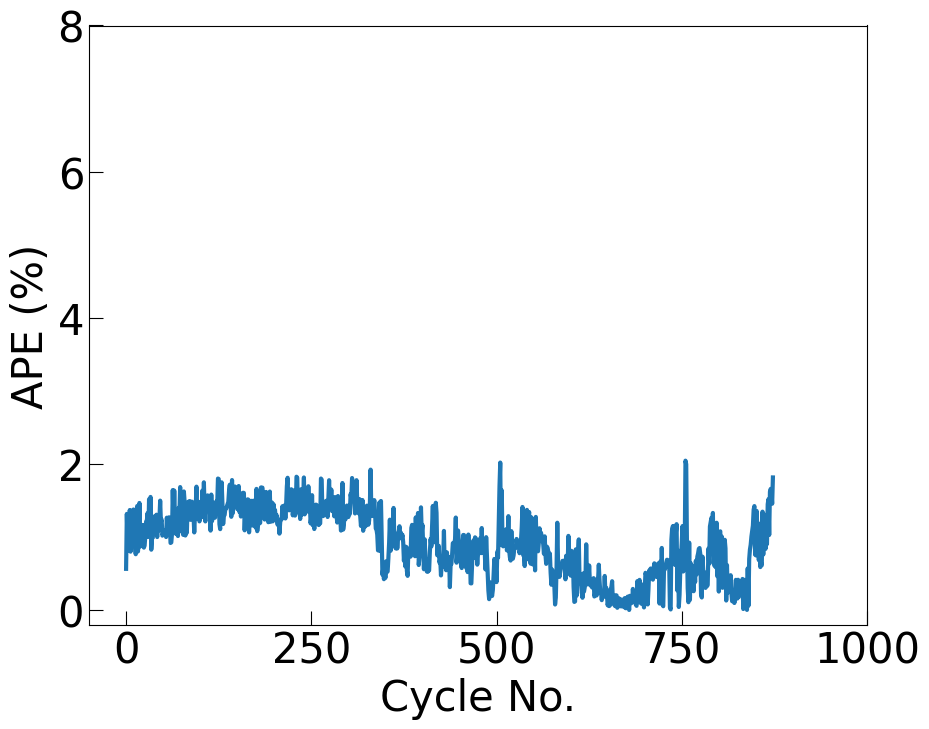

MAPE : 0.009265862994624346


In [ ]:
plt.figure(figsize=(10,8))
plt.plot(df['APE'],linewidth=3)
plt.ylabel('APE (%)')
plt.ylim(-0.2,8)
plt.xlim(-50,1000)
plt.xticks(np.arange(0,1250,250))
plt.xlabel('Cycle No.')
plt.tick_params(direction='in',length=10)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive//battery capcity estimation/new figure/fig8b.png',dpi=600)
plt.show()
# plt.legend()
print("MAPE : {}".format(df['APE'].mean(axis=0)/100))

In [ ]:
# finetuned 와 비교하기위한 목적의 plot(1/2) - previous ape
y= y.tolist()
preds = preds.tolist()

pre_df = pd.DataFrame({"true":y,"prediction":preds})

pre_df['cycle']=range(len(pre_df))
pre_df['cycle'] = pre_df['cycle']+1

pre_df['APE']= np.abs((pre_df['prediction']-pre_df['true'])/pre_df['true'])*100

In [ ]:
# finetuned 와 비교하기위한 목적의 plot(2/2) - finetune ape
y= y.tolist()
preds = preds.tolist()

fine_df = pd.DataFrame({"true":y,"prediction":preds})

fine_df['cycle']=range(len(fine_df))
fine_df['cycle'] = fine_df['cycle']+1

fine_df['APE']= np.abs((fine_df['prediction']-fine_df['true'])/fine_df['true'])*100

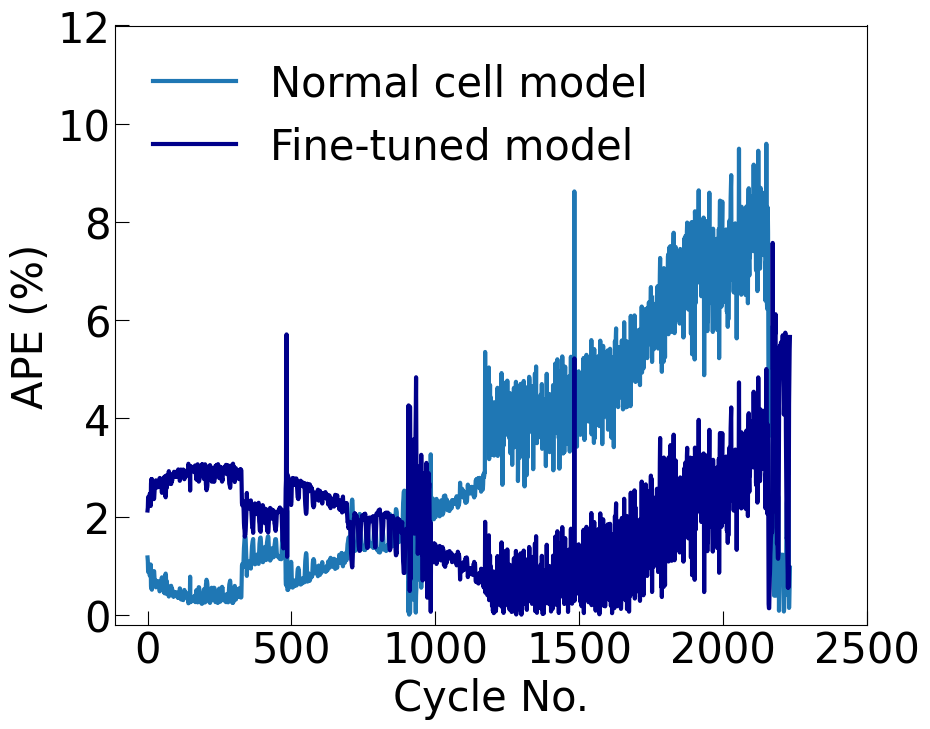

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(pre_df['APE'],linewidth=3,label='Normal cell model')
plt.plot(fine_df['APE'],color='darkblue',linewidth=3,label = 'Fine-tuned model')
plt.ylabel('APE (%)')
plt.ylim(-0.2,12)
#plt.xlim(-50,2000) # b1c16용
plt.xticks(np.arange(0,3000,500))
plt.xlabel('Cycle No.')
plt.tick_params(direction='in',length=10)
plt.tight_layout()
plt.legend(frameon=False)
plt.savefig('/content/drive/MyDrive//battery capcity estimation/new figure/fig11d.png',dpi=600)
plt.show()
# plt.legend()
# print("MAPE : {}".format(df['APE'].mean(axis=0)/100))